In [1]:
import torch.nn as nn
import torch
from tqdm import tqdm_notebook as tqdm
import torchvision.models as models
import numpy as np
import json
from PIL import Image
from transformers import AdamW
import os
import torch.utils.data as data
from pycocotools.coco import COCO
from torchvision import transforms
import pytorch_lightning as pl
%matplotlib inline
import matplotlib.pyplot as plt 

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
BertModel = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased').to(device)
BertModel.eval()

Using cache found in C:\Users\lycan/.cache\torch\hub\huggingface_pytorch-transformers_master


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(i

In [3]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        resnet = models.resnet101(pretrained=True)
        self.resnet = nn.Sequential(*list(resnet.children())[:-1])
        for p in self.resnet.parameters():
            p.requires_grad = False
    def forward(self, images):
        out = self.resnet(images)
        # batch_size, img size, imgs size, 2048
        out = out.permute(0, 2, 3, 1)
        return out #[2, 7,7, 2048]

In [4]:
class mydataset(data.Dataset):
    def __init__(self, root, json,tokenizer, transform=None):
        self.root = root
        self.coco = COCO(json)
        self.ids = list(self.coco.anns.keys())
        self.tokenizer = tokenizer
        self.transform = transform
    def __getitem__(self, index):
        coco = self.coco
        tokenizer = self.tokenizer
        ann_id = self.ids[index]
        caption = coco.anns[ann_id]['caption']
        img_id = coco.anns[ann_id]['image_id']
        path = coco.loadImgs(img_id)[0]['file_name']
        image = Image.open(os.path.join(self.root, path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        token_ids = tokenizer.encode(caption, add_special_tokens=True)
        tokens_tensor = torch.tensor(token_ids)
        return image.to(device), tokens_tensor.to(device)
    def __len__(self):
        return len(self.ids)
encoder = Encoder().to(device)
encoder.eval()
def collate_fn(data):
    data.sort(key=lambda  x: len(x[1]), reverse=True)
    images, captions = zip(*data)
    lengths = torch.tensor([len(cap) for cap in captions])
    lengths, sort_ind = lengths.sort(dim=0, descending=True)
    sort_ind=[i.item() for i in sort_ind]
    img = torch.stack(images, 0)
    img = img[sort_ind]
    with torch.no_grad():
        img = encoder(img)
    Captions=[]
    for i in range(len(captions)):
        time = int(torch.ceil(max(lengths)/lengths[i]).item())
        Captions.append(captions[i].expand((time,captions[i].shape[-1])).flatten()[:max(lengths)])
    inputs = torch.stack(Captions, 0)    
    inputs = inputs[sort_ind]
    return img[:,0,0,:], inputs#[2, 14, 14, 2048]
def get_loader(method, tokenizer, batch_size):
    if method == 'train':
        root = 'D:\\yolodataset\\coco\\train2017'
        json = 'D:\\yolodataset\\coco\\annotations\\captions_train2017.json'
        shuffle = True
    else:
        root = 'D:\\yolodataset\\coco\\val2017'
        json = 'D:\\yolodataset\\coco\\annotations\\captions_val2017.json'
        shuffle = False
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
    ])
    coco = mydataset(root=root, json=json, tokenizer = tokenizer, transform=transform)
    data_loader = torch.utils.data.DataLoader(dataset=coco,
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              num_workers=0,
                                              collate_fn=collate_fn)
    return data_loader

In [5]:
batch_size = 64
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'distilbert-base-uncased') 
train_loader = get_loader('train', tokenizer, batch_size)
val_loader = get_loader('val', tokenizer, batch_size)
weight=torch.ones(tokenizer.vocab_size)
weight[0]=1e-6
#criterion = nn.CrossEntropyLoss(weight=weight,ignore_index=0).to(device)
criterion = nn.CrossEntropyLoss().to(device)

Using cache found in C:\Users\lycan/.cache\torch\hub\huggingface_pytorch-transformers_master


loading annotations into memory...
Done (t=0.77s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [6]:
class Attention(nn.Module):

    def __init__(self, encoder_dim, decoder_dim,embed_dim):

        super(Attention, self).__init__()
        
        self.softmax = nn.Softmax(dim=1)  # softmax layer to calculate weights
        self.imgattk = nn.Linear(encoder_dim, decoder_dim)
        self.imgattq = nn.Linear(encoder_dim, decoder_dim)
        self.embattk = nn.Linear(decoder_dim, decoder_dim)
        self.embattq = nn.Linear(decoder_dim, decoder_dim)

    def forward(self, imgs, embeddings):#b,decode_dim

        imgQ = self.imgattq(imgs)
        imgK = self.imgattk(imgs)
        embeddingsQ = self.embattq(embeddings)
        embeddingsK = self.embattk(embeddings)
        imgs = imgs*self.softmax(embeddingsQ*imgK)
        embeddings = embeddings*self.softmax(embeddingsK*imgQ)
        return torch.cat([embeddings, imgs], dim=1)


attention on hidden

In [7]:
class Attention(nn.Module):

    def __init__(self, encoder_dim, decoder_dim,embed_dim):

        super(Attention, self).__init__()
        self.att1 = nn.Linear(encoder_dim, decoder_dim)
        self.att2 = nn.Linear(embed_dim, decoder_dim)
        
        self.softmax = nn.Softmax(dim=1)  # softmax layer to calculate weights
        self.imgattk = nn.Linear(decoder_dim, decoder_dim)
        self.imgattq = nn.Linear(decoder_dim, decoder_dim)
        self.embattk = nn.Linear(embed_dim, decoder_dim)
        self.embattq = nn.Linear(embed_dim, decoder_dim)

    def forward(self, imgs,h, embeddings):#b,decode_dim
        att1 = self.att1(imgs)
        att2 = self.att2(embeddings)
        imgs = att1*self.softmax(att1*h)
        embeddings = att2*self.softmax(att2*h)
        imgQ = self.imgattq(imgs)
        imgK = self.imgattk(imgs)
        embeddingsQ = self.embattq(embeddings)
        embeddingsK = self.embattk(embeddings)
        imgs = imgs*self.softmax(embeddingsQ*imgK)
        embeddings = embeddings*self.softmax(embeddingsK*imgQ)
        return torch.cat([embeddings, imgs], dim=1)


In [8]:
class Decoder(nn.Module):
    def __init__(self, tokenizer):
        super(Decoder, self).__init__()
        self.encoder_dim = 2048
        self.embed_dim = 768
        self.decoder_dim = 768
        self.vocab_size = tokenizer.vocab_size
        self.dropout = 0.5     
        self.Dropout = nn.Dropout(p=self.dropout)
        self.decode_step = nn.LSTMCell(self.decoder_dim*2, self.decoder_dim)
        self.h_lin = nn.Linear(self.encoder_dim, self.decoder_dim)
        self.c_lin = nn.Linear(self.encoder_dim, self.decoder_dim)
        self.fc = nn.Linear(self.decoder_dim, self.vocab_size)
        self.attention = Attention(self.encoder_dim, self.decoder_dim,self.embed_dim)
        
    def forward(self, imgs, tokens_tensor):#[b,2048]
        batch_size = imgs.size(0)
        max_dec_len = tokens_tensor.size(-1)
        encoder_dim = imgs.size(-1)
        vocab_size = self.vocab_size
        # init hidden state  
        h = self.h_lin(imgs)
        c = self.c_lin(imgs)
        Logits = torch.zeros(batch_size,max_dec_len,vocab_size).to(device)
        for i in range(max_dec_len):
            with torch.no_grad():
                embeddings = BertModel(tokens_tensor[:,i].unsqueeze(1).to(device))[0][:,0,:]
            input=self.attention(imgs,h,embeddings)
            h,c =self.decode_step(input,(h, c))
            Logits[:,i,:] = self.fc(self.Dropout(h))
        return Logits

In [9]:
def beam(img,max_len=40,n=5):
    tt = torch.zeros(n, max_len,dtype = torch.long).to(device)
    tt[:,0]=101
    with torch.no_grad():
        imgs = encoder(img.unsqueeze(0))[:,0,0,:]
    imgs = imgs.expand((n,-1))
    h = EDnet.decoder.h_lin(imgs)
    c = EDnet.decoder.c_lin(imgs)
    #initialize probability
    prob={i:1 for i in range(n)}
    for i in range(1,max_len):
        cand = {}
        with torch.no_grad():
            embeddings = BertModel(tt[:,i-1].unsqueeze(1).to(device))[0][:,0,:]
        input=EDnet.decoder.attention(imgs,h,embeddings)
        h, c = EDnet.decoder.decode_step(input,(h, c))#n,dim
        logits = EDnet.decoder.fc(h)#n,vs
        probs =nn.Softmax(dim=1)(logits)
        for j in range(n):
            tops = torch.topk(probs[j], n)
            for k in range(n):
                cand[prob[j]*tops[0][k].item()] = (j,tops[1][k].item())
        p=list(cand.keys())
        p.sort(reverse=True)
        prob = {i:p[i] for i in range(n)}
        temp = torch.zeros(n, max_len,dtype = torch.long).to(device)
        for j in range(n):
            og,addon = cand[prob[j]]
            temp[j] = tt[og]
            temp[j,i] = addon
        tt = temp
    return tt[0]

In [10]:
class network(pl.LightningModule):
    def __init__(self,tokenizer=tokenizer,lr = 4e-4):
        super().__init__()
        self.vocab_size=tokenizer.vocab_size
        self.decoder = Decoder(tokenizer).to(device)
        self.lr = lr
    def forward(self,imgs,token_tensor):
        self.decoder.eval()
        logits = self.decoder(imgs,token_tensor[:,:-1])
        return logits
    def training_step(self, batch, batch_idx):
        self.decoder.train()
        img, inputs = batch
        logits = self.decoder(img,inputs[:,:-1])
        logits = logits.view((-1,logits.shape[-1]))
        loss = criterion(logits,inputs[:,1:].flatten())
        return loss
    def configure_optimizers(self):
        optimizer = AdamW(params=self.decoder.parameters(),lr=self.lr)
        sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max = 1e3, eta_min = 1e-4)
        return ({'optimizer': optimizer,'scheduler': sched,'interval': 'step','frequency': 50})
    def validation_step(self, batch, batch_idx):
        self.decoder.eval()
        img, inputs = batch
        logits = self.decoder(img,inputs[:,:-1])
        pred = torch.argmax(logits,dim=-1)
        acc = (inputs[:,1:]==pred).float().mean()
        self.log('accuracy', acc, prog_bar=True)
        return acc

In [11]:
EDnet = network().to(device)
EDnet = EDnet.load_from_checkpoint('C:\\Users\\lycan\\Documents\\cu\\nlp\\4705\\hw5\\lightning_logs\\epoch=2-step=27740.ckpt')
trainer = pl.Trainer(gpus=1,max_epochs=3, progress_bar_refresh_rate=100)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [12]:
trainer.fit(EDnet, train_loader, val_loader)


  | Name    | Type    | Params
------------------------------------
0 | decoder | Decoder | 38.2 M
------------------------------------
38.2 M    Trainable params
0         Non-trainable params
38.2 M    Total params


1

In [13]:
def greedy(imgs,max_len=40):
    EDnet.decoder.eval()
    encoder_dim = 768
    with torch.no_grad():
        imgs = encoder(imgs.unsqueeze(0))[:,0,0,:]
    h = EDnet.decoder.h_lin(imgs) 
    c = EDnet.decoder.c_lin(imgs) 
    tt = torch.zeros(1, max_len,dtype = torch.long).to(device)
    tt[0,0]=101
    for i in range(1,max_len):
        with torch.no_grad():
            embeddings = BertModel(tt[:,i-1].unsqueeze(1).to(device))[0][:,0,:]
        input=EDnet.decoder.attention(imgs,h,embeddings)
        h,c =EDnet.decoder.decode_step(input,(h, c))
        logits = EDnet.decoder.fc(h)[0] 
        tt[0,i]=torch.argmax(logits)
    return tt[0]

In [14]:
def translator(tt):
    tt=tokenizer.convert_ids_to_tokens(tt)
    end = len(tt)-1
    if '.' in tt and '[SEP]' in tt:
        end = min(tt.index('.'),tt.index('[SEP]'))
    elif '[SEP]' in tt:
        end = tt.index('[SEP]')
    elif '.' in tt:
        end = tt.index('.')
    tt= tt[:end]
    tt = [i for i in tt if i not in ['[CLS]','[PAD]']]
    tt=tokenizer.convert_tokens_to_string(tt)
    return tt

In [15]:
root = 'D:\\yolodataset\\coco\\val2017'
json = 'D:\\yolodataset\\coco\\annotations\\captions_val2017.json'
transform = transforms.Compose([
        transforms.Resize(224),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
    ])
coco = mydataset(root=root, json=json, tokenizer = tokenizer, transform=transform)

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


In [16]:
EDnet=EDnet.to(device)
EDnet.eval()
def vslz(cap1,capg= None,capb = None,img=None):
    transform = transforms.Compose([
                transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225),(1/0.229, 1/0.224, 1/0.225))])
    img = transform(img)
    plt.imshow(img.permute(1,2,0))
    plt.show()
    if capg is not None:
        print('greedy: ',capg)
    if capb is not None:
        print('beam: ',capb)
    print('true_cap: ',cap1)

In [17]:
def random_test(n = 5):
    for _ in range(n):
        index = np.random.randint(len(coco))
        img,tt = coco[index]
        cap = translator(tt.to(device))
        tt = greedy(img.to(device))
        pred1 = translator(tt)
        tt = beam(img,n = 10)
        pred2 = translator(tt)
        vslz(cap1=cap,capg= pred1,capb= pred2,img=img.cpu())

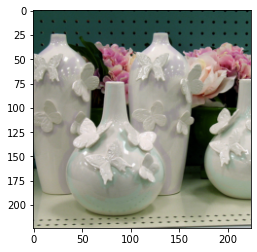

greedy:  a vase with flowers in it sitting on a table
beam:  a vase with a vases on it
true_cap:  four different sized vases decorated with various sized butterflys


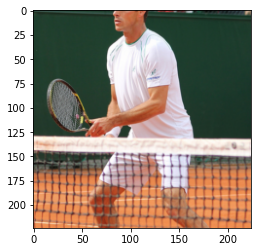

greedy:  a man is playing tennis on a tennis court
beam:  a tennis players on a tennis court with a racket
true_cap:  a man in white is playing on a tennis court


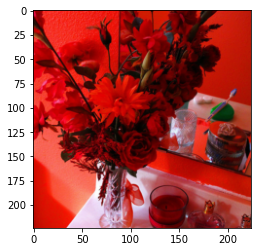

greedy:  a vase with flowers in it sitting on a table
beam:  a vase filled with flowers on a vase
true_cap:  red flowers sitting in a vase with a red wall behind them


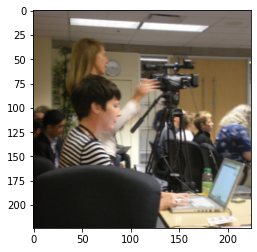

greedy:  a man sitting at a table with a laptop computer
beam:  a group of a desk with a laptop computer
true_cap:  a woman standing in front of a camera in a room filled with a group of people


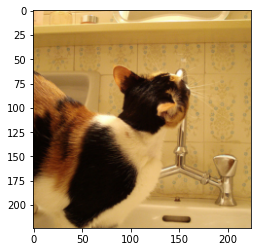

greedy:  a cat is sitting on a toilet in a bathroom
beam:  a cat is sitting in a bathroom sink
true_cap:  a cat drinking water from a bathroom faucet


In [18]:
random_test(5)